# Creating the Emotion Dataset

In this notebook, we retrieve a subset of the [emotion](https://huggingface.co/datasets/dair-ai/emotion) dataset and generate frozen feature representations to be used in convex optimization algorithms.

In [14]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset
from tqdm import tqdm
import time
import numpy as np
import datetime
import random
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA

from datasets import load_dataset
from transformers import AutoTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup

In [2]:
LEARNING_RATE = 2e-5
ADAMW_TOLERANCE = 1e-8
BATCH_SIZE = 32
EPOCHS = 2
SEED = 123
FILENAME = "bert_emotion_finetuned"

## Finetune BERT Model

In order to create the dataset, we apply the following steps:
1. Select an initial training subset of 16,000 examples, and partition them randomly into two 8,000 example subsets.
2. The first half from the previous step is used to finetune a pre-trained BERT model for sequence classification to generate a feature representation.
3. The representation is applied to the unused 8,000 to create frozen feature vectors for these texts.
4. The feature vectors are then reduced via PCA to 45 dimensions. Because there are six classes, this results in 270 parameters for multinomial logistic regression.

In [3]:
class Emotion(Dataset):
    def __init__(self, dataset, split, tokenizer, idx=None, max_length=80, train_idx=None):
        # Tokenize all of the sentences and map the tokens to thier word IDs.
        input_ids = []
        attn_masks = []

        # For every sentence...
        sentences = dataset[split]["text"]
        if split != "train":
            idx = np.arange(len(sentences))
        for i in tqdm(idx):
            sent = sentences[i]
            encoded_dict = tokenizer.encode_plus(
                sent,  # Sentence to encode.
                add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                max_length=max_length,
                pad_to_max_length=True,
                truncation=True,
                return_attention_mask = True,   # Construct attn. masks.
                return_tensors="pt",  # Return pytorch tensors.
            )

            # Add the encoded sentence to the list.
            input_ids.append(encoded_dict["input_ids"])
            attn_masks.append(encoded_dict["attention_mask"])

        self.input_ids = torch.cat(input_ids, dim=0)
        self.attn_masks = torch.cat(attn_masks, dim=0)
        self.labels = torch.tensor(np.array(dataset[split]["label"])[idx]).long()

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, i):
        return self.input_ids[i], self.attn_masks[i], self.labels[i]

In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
dataset = load_dataset("dair-ai/emotion", trust_remote_code=True)

/home/ronak/miniconda3/envs/dro/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [7]:
# Create dataloaders.
np.random.seed(123)
n = 16000
finetune_idx = np.random.choice(n, 8000, replace=False)
train_idx = np.delete(np.arange(n), finetune_idx)
print(np.intersect1d(finetune_idx, train_idx))
print(len(np.unique(np.union1d(finetune_idx, train_idx))))

train_dataset = Emotion(dataset, "train", tokenizer, idx=finetune_idx)
train_dataloader = DataLoader(
    train_dataset, sampler=RandomSampler(train_dataset), batch_size=BATCH_SIZE
)
print("{:>5,} training samples.".format(len(train_dataset)))

[]
16000


  0%|          | 0/8000 [00:00<?, ?it/s]/home/ronak/miniconda3/envs/dro/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 8000/8000 [00:01<00:00, 6548.10it/s]


8,000 training samples.


In [8]:
val_dataset = Emotion(dataset, "validation", tokenizer)
validation_dataloader = DataLoader(
    val_dataset, sampler=SequentialSampler(val_dataset), batch_size=BATCH_SIZE
)
print("{:>5,} validation samples.".format(len(val_dataset)))

test_dataset = Emotion(dataset, "test", tokenizer)
test_dataloader = DataLoader(
    test_dataset, sampler=RandomSampler(test_dataset), batch_size=BATCH_SIZE
)
print("{:>5,} test samples.".format(len(test_dataset)))

100%|██████████| 2000/2000 [00:00<00:00, 6716.87it/s]


2,000 validation samples.


100%|██████████| 2000/2000 [00:00<00:00, 7068.26it/s]

2,000 test samples.


In [9]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
print("Running on '%s'." % device)

Running on 'cuda:0'.


## Train Embedding Model

We now use the held out 8,000 examples to finetune the BERT model.

In [10]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=6,
    output_attentions=False,
    output_hidden_states=True,
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, eps = ADAMW_TOLERANCE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = EPOCHS * BATCH_SIZE * len(train_dataloader))

In [15]:
# Seed everything.
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

training_stats = []
total_t0 = time.time()
for epoch_i in range(EPOCHS):

    # ========================================
    #               Training
    # ========================================

    print("")
    print("======== Epoch {:} / {:} ========".format(epoch_i + 1, EPOCHS))
    print("Training...")

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(
                "  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.".format(
                    step, len(train_dataloader), elapsed
                )
            )

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        output = model(
            b_input_ids,
            attention_mask=b_input_mask,
            labels=b_labels,
            return_dict=True,
        )

        loss = output.loss
        logits = output.logits
        

        total_train_loss += loss.item()

        loss.backward()

        # TODO: See if this is needed.
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            output = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
            loss = output.loss
            logits = output.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            "epoch": epoch_i + 1,
            "Training Loss": avg_train_loss,
            "Valid. Loss": avg_val_loss,
            "Valid. Accur.": avg_val_accuracy,
            "Training Time": training_time,
            "Validation Time": validation_time,
        }
    )

print("")
print("Training complete!")

print(
    "Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0))
)

# Save the model.
torch.save(model, f"{FILENAME}.pt")
pickle.dump(
    training_stats, open(f"training_stats_{FILENAME}.p", "wb")
)


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    250.    Elapsed: 0:00:07.
  Batch    80  of    250.    Elapsed: 0:00:13.
  Batch   120  of    250.    Elapsed: 0:00:19.
  Batch   160  of    250.    Elapsed: 0:00:25.
  Batch   200  of    250.    Elapsed: 0:00:31.
  Batch   240  of    250.    Elapsed: 0:00:37.

  Average training loss: 0.85
  Training epcoh took: 0:00:39

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.31
  Validation took: 0:00:03

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    250.    Elapsed: 0:00:07.
  Batch    80  of    250.    Elapsed: 0:00:13.
  Batch   120  of    250.    Elapsed: 0:00:20.
  Batch   160  of    250.    Elapsed: 0:00:26.
  Batch   200  of    250.    Elapsed: 0:00:33.
  Batch   240  of    250.    Elapsed: 0:00:40.

  Average training loss: 0.22
  Training epcoh took: 0:00:41

Running Validation...
  Accuracy: 0.92
  Validation Loss: 0.23
  Validation took: 0:00:03

Training complete!
Total training took 0:01

In [16]:
# ========================================
#               Testing
# ========================================


t0 = time.time()

model.eval()

total_test_accuracy = 0
total_test_loss = 0

for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        output = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels,
        )
        loss = output.loss
        logits = output.logits

    total_test_loss += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to("cpu").numpy()

    total_test_accuracy += flat_accuracy(logits, label_ids)

avg_test_accuracy = total_test_accuracy / len(test_dataloader)
print("  Accuracy: {0:.2f}".format(avg_test_accuracy))
avg_test_loss = total_test_loss / len(test_dataloader)
test_time = format_time(time.time() - t0)
print("  Test Loss: {0:.2f}".format(avg_test_loss))
print("  Test took: {:}".format(test_time))

  Accuracy: 0.91
  Test Loss: 0.25
  Test took: 0:00:03


## Visualize Embeddings

We now attempt to visualize the learned embeddings along with their class label to inspect the signal in the features.

In [17]:
%%capture

model = torch.load(f"{FILENAME}.pt")
model.eval()

In [18]:
def get_hidden_states(dataloader):
    model.eval()
    hidden_states = []
    labels = []
    for batch in tqdm(dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():
            output = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
            hidden_states.append(torch.mean(output.hidden_states[-1], dim=1))
            labels.append(b_labels)
    return torch.cat(hidden_states, dim=0).cpu().numpy(), torch.cat(labels, dim=0).cpu().numpy()

In [19]:
split_dataset = Emotion(dataset, "train", tokenizer, idx=train_idx)
split_dataloader = DataLoader(
    split_dataset, sampler=RandomSampler(split_dataset), batch_size=BATCH_SIZE
)
print("{:>5,} training samples.".format(len(split_dataset)))

  0%|          | 0/8000 [00:00<?, ?it/s]/home/ronak/miniconda3/envs/dro/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 8000/8000 [00:01<00:00, 6293.34it/s]

8,000 training samples.


In [20]:
x_train, y_train = get_hidden_states(split_dataloader)
x_val, y_val = get_hidden_states(validation_dataloader)
x_test, y_test = get_hidden_states(test_dataloader)

x_train = x_train / np.linalg.norm(x_train, axis=1)[:, None]
x_val = x_val / np.linalg.norm(x_val, axis=1)[:, None]
x_test = x_test / np.linalg.norm(x_test, axis=1)[:, None]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

100%|██████████| 63/63 [00:02<00:00, 21.13it/s]

(8000, 768)
(2000, 768)
(2000, 768)


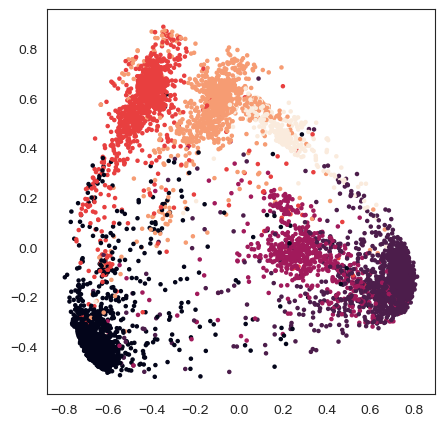

In [21]:
sns.set_style("white")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

x = PCA(n_components=2).fit_transform(x_train)

ax.scatter(x[:, 0], x[:, 1], c=y_train, s=5)

In [22]:
embed_dim = x_train.shape[1]
pca = PCA(n_components=embed_dim).fit(x_train)

threshold = 0.95
cumsum = 0.0
for i, eig in enumerate(pca.explained_variance_ratio_):
    cumsum += eig
    if cumsum >= threshold:
        n_components = i + 1
        print(f"{cumsum} variance explained by {n_components}/{embed_dim} components.")
        break

X_train = pca.transform(x_train)[:, 0:n_components]
X_val   = pca.transform(x_val)[:, 0:n_components]
X_test  = pca.transform(x_test)[:, 0:n_components]

0.9502273388789035 variance explained by 45/768 components.


In [23]:
try:
    probe = LogisticRegressionCV(Cs=5, cv=3, solver="liblinear").fit(X_train, y_train)
except KeyboardInterrupt:
    print("Graceful Exit")

In [24]:
accuracy_score(y_val, probe.predict(X_val))

0.9265

In [ ]:
# np.save("../data/emotion/X_train.npy", X_train)
# np.save("../data/emotion/y_train.npy", y_train)
# np.save("../data/emotion/X_val.npy", X_val)
# np.save("../data/emotion/y_val.npy", y_val)
# np.save("../data/emotion/X_test.npy", X_test)
# np.save("../data/emotion/y_test.npy", y_test)